## Small Project - fish mask recovery (40%)

In this project, your goal is to recover an occluded or a broken fish mask back to its original shape.

Please finished running the baseline first, and then you can use any method (besides using the test set groundtruth) to improve the accuracy.

Some suggestions: try some data augmentation, collect more fish masks training data online (you can do it with Segment Anything!), use a stronger model...etc

You will need to submit your code (this notebook) and a report.pdf to Canvas.

In your report, please include your lowest MSE on test set, your experiment results, generated images, and do not just paste/screenshot all your code!

**Failing to include the required info and follow the above rules in your report can resulted in points deduction.**

Grading policy: Performance Ranking (30%), Report (10%)

![image.png](attachment:image.png)

### A Simple Baseline

In [125]:
import os
import os.path as osp
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [126]:
# fix file path in google colab
from google.colab import drive
drive.mount('/content/drive')

# change path
import os
os.chdir('/content/drive/MyDrive/HW5/p3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
# Custom Dataset class
class MaskDataset(Dataset):
    def __init__(self, img_dir, transform1, transform2):
        self.img_dir = img_dir
        self.imgs = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = osp.join(self.img_dir, self.imgs[idx])
        image = Image.open(img_path).convert('L')

        # Apply other transformations
        original_image = self.transform1(image)
        erased_image = self.transform2(image)

        # Return the same image as both input and target
        return erased_image, original_image

In [128]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[8, 16, 32, 64]):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.double_conv(features[-1], features[-1] * 2)

        # Decoder (upsampling)
        self.ups = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(self.double_conv(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """ Two consecutive convolutional layers with ReLU activations """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # Upsample
            skip_connection = skip_connections[idx // 2]

            # Concatenate along the channel dimension
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        # Final convolution
        return self.final_conv(x)

In [129]:
# TODO Implement the transforms following the simple baseline's pipeline

transform1 = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1]
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomErasing(p=1.0)  # Randomly erase
    # transforms.RandomErasing(p=0.5, scale=(0.01, 0.15), ratio=(0.5, 2.0))  # Randomly erase
])


# Load the dataset
dataset = MaskDataset('train', transform1, transform2)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Initialize the model, decider your own model arguments
model = UNet(in_channels=1, out_channels=1, features=[8, 16, 32, 64])

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
model.train()
num_epochs = 200

In [130]:
# training loop
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(dataloader, desc=f"Epoch [{epoch + 1}/{num_epochs}]", unit="batch") as epoch:
        for erased_images, original_images in epoch:
            erased_images, original_images = erased_images.to(device), original_images.to(device)

            # Forward pass
            outputs = model(erased_images)
            loss = criterion(outputs, original_images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update tqdm with the current loss
            epoch.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(dataloader)
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
    print(f"Average Loss: {avg_loss:.4f}")


Epoch [1/200]: 100%|██████████| 46/46 [00:01<00:00, 33.66batch/s, loss=0.396]


Average Loss: 0.4100


Epoch [2/200]: 100%|██████████| 46/46 [00:01<00:00, 36.97batch/s, loss=0.134]


Average Loss: 0.2437


Epoch [3/200]: 100%|██████████| 46/46 [00:01<00:00, 41.53batch/s, loss=0.252]


Average Loss: 0.1827


Epoch [4/200]: 100%|██████████| 46/46 [00:01<00:00, 43.00batch/s, loss=0.172]


Average Loss: 0.1388


Epoch [5/200]: 100%|██████████| 46/46 [00:01<00:00, 43.16batch/s, loss=0.173]


Average Loss: 0.1242


Epoch [6/200]: 100%|██████████| 46/46 [00:01<00:00, 43.02batch/s, loss=0.124]


Average Loss: 0.1151


Epoch [7/200]: 100%|██████████| 46/46 [00:01<00:00, 43.54batch/s, loss=0.0763]


Average Loss: 0.1009


Epoch [8/200]: 100%|██████████| 46/46 [00:01<00:00, 43.99batch/s, loss=0.105]


Average Loss: 0.0980


Epoch [9/200]: 100%|██████████| 46/46 [00:01<00:00, 43.53batch/s, loss=0.0488]


Average Loss: 0.0937


Epoch [10/200]: 100%|██████████| 46/46 [00:01<00:00, 44.08batch/s, loss=0.117]


Average Loss: 0.0875


Epoch [11/200]: 100%|██████████| 46/46 [00:01<00:00, 43.25batch/s, loss=0.0544]


Average Loss: 0.0803


Epoch [12/200]: 100%|██████████| 46/46 [00:01<00:00, 35.79batch/s, loss=0.0301]


Average Loss: 0.0853


Epoch [13/200]: 100%|██████████| 46/46 [00:01<00:00, 35.70batch/s, loss=0.0725]


Average Loss: 0.0804


Epoch [14/200]: 100%|██████████| 46/46 [00:01<00:00, 34.90batch/s, loss=0.0207]


Average Loss: 0.0774


Epoch [15/200]: 100%|██████████| 46/46 [00:01<00:00, 43.37batch/s, loss=0.0921]


Average Loss: 0.0807


Epoch [16/200]: 100%|██████████| 46/46 [00:01<00:00, 44.33batch/s, loss=0.0651]


Average Loss: 0.0688


Epoch [17/200]: 100%|██████████| 46/46 [00:01<00:00, 42.38batch/s, loss=0.0697]


Average Loss: 0.0509


Epoch [18/200]: 100%|██████████| 46/46 [00:01<00:00, 42.29batch/s, loss=0.0285]


Average Loss: 0.0364


Epoch [19/200]: 100%|██████████| 46/46 [00:01<00:00, 43.26batch/s, loss=0.0383]


Average Loss: 0.0304


Epoch [20/200]: 100%|██████████| 46/46 [00:01<00:00, 42.82batch/s, loss=0.0135]


Average Loss: 0.0279


Epoch [21/200]: 100%|██████████| 46/46 [00:01<00:00, 41.82batch/s, loss=0.0394]


Average Loss: 0.0240


Epoch [22/200]: 100%|██████████| 46/46 [00:01<00:00, 44.33batch/s, loss=0.0395]


Average Loss: 0.0227


Epoch [23/200]: 100%|██████████| 46/46 [00:01<00:00, 43.81batch/s, loss=0.0246]


Average Loss: 0.0191


Epoch [24/200]: 100%|██████████| 46/46 [00:01<00:00, 37.83batch/s, loss=0.0106]


Average Loss: 0.0185


Epoch [25/200]: 100%|██████████| 46/46 [00:01<00:00, 36.72batch/s, loss=0.0334]


Average Loss: 0.0180


Epoch [26/200]: 100%|██████████| 46/46 [00:01<00:00, 34.45batch/s, loss=0.015]


Average Loss: 0.0166


Epoch [27/200]: 100%|██████████| 46/46 [00:01<00:00, 36.12batch/s, loss=0.0109]


Average Loss: 0.0148


Epoch [28/200]: 100%|██████████| 46/46 [00:01<00:00, 37.73batch/s, loss=0.00896]


Average Loss: 0.0147


Epoch [29/200]: 100%|██████████| 46/46 [00:01<00:00, 40.24batch/s, loss=0.00976]


Average Loss: 0.0158


Epoch [30/200]: 100%|██████████| 46/46 [00:01<00:00, 40.13batch/s, loss=0.0368]


Average Loss: 0.0156


Epoch [31/200]: 100%|██████████| 46/46 [00:01<00:00, 42.24batch/s, loss=0.00727]


Average Loss: 0.0130


Epoch [32/200]: 100%|██████████| 46/46 [00:01<00:00, 41.51batch/s, loss=0.0169]


Average Loss: 0.0131


Epoch [33/200]: 100%|██████████| 46/46 [00:01<00:00, 42.15batch/s, loss=0.00482]


Average Loss: 0.0128


Epoch [34/200]: 100%|██████████| 46/46 [00:01<00:00, 41.69batch/s, loss=0.00871]


Average Loss: 0.0115


Epoch [35/200]: 100%|██████████| 46/46 [00:01<00:00, 40.59batch/s, loss=0.00677]


Average Loss: 0.0109


Epoch [36/200]: 100%|██████████| 46/46 [00:01<00:00, 35.32batch/s, loss=0.00697]


Average Loss: 0.0142


Epoch [37/200]: 100%|██████████| 46/46 [00:01<00:00, 35.10batch/s, loss=0.0244]


Average Loss: 0.0147


Epoch [38/200]: 100%|██████████| 46/46 [00:01<00:00, 32.92batch/s, loss=0.0125]


Average Loss: 0.0125


Epoch [39/200]: 100%|██████████| 46/46 [00:01<00:00, 41.04batch/s, loss=0.0251]


Average Loss: 0.0124


Epoch [40/200]: 100%|██████████| 46/46 [00:01<00:00, 41.59batch/s, loss=0.00466]


Average Loss: 0.0129


Epoch [41/200]: 100%|██████████| 46/46 [00:01<00:00, 41.28batch/s, loss=0.0382]


Average Loss: 0.0144


Epoch [42/200]: 100%|██████████| 46/46 [00:01<00:00, 41.96batch/s, loss=0.0087]


Average Loss: 0.0128


Epoch [43/200]: 100%|██████████| 46/46 [00:01<00:00, 42.35batch/s, loss=0.00941]


Average Loss: 0.0106


Epoch [44/200]: 100%|██████████| 46/46 [00:01<00:00, 40.44batch/s, loss=0.0122]


Average Loss: 0.0120


Epoch [45/200]: 100%|██████████| 46/46 [00:01<00:00, 41.59batch/s, loss=0.0196]


Average Loss: 0.0117


Epoch [46/200]: 100%|██████████| 46/46 [00:01<00:00, 40.56batch/s, loss=0.0148]


Average Loss: 0.0119


Epoch [47/200]: 100%|██████████| 46/46 [00:01<00:00, 38.78batch/s, loss=0.00535]


Average Loss: 0.0114


Epoch [48/200]: 100%|██████████| 46/46 [00:01<00:00, 35.14batch/s, loss=0.0168]


Average Loss: 0.0122


Epoch [49/200]: 100%|██████████| 46/46 [00:01<00:00, 33.00batch/s, loss=0.00225]


Average Loss: 0.0098


Epoch [50/200]: 100%|██████████| 46/46 [00:01<00:00, 37.44batch/s, loss=0.0141]


Average Loss: 0.0101


Epoch [51/200]: 100%|██████████| 46/46 [00:01<00:00, 41.15batch/s, loss=0.00937]


Average Loss: 0.0109


Epoch [52/200]: 100%|██████████| 46/46 [00:01<00:00, 40.71batch/s, loss=0.0269]


Average Loss: 0.0115


Epoch [53/200]: 100%|██████████| 46/46 [00:01<00:00, 39.89batch/s, loss=0.00317]


Average Loss: 0.0122


Epoch [54/200]: 100%|██████████| 46/46 [00:01<00:00, 42.62batch/s, loss=0.011]


Average Loss: 0.0110


Epoch [55/200]: 100%|██████████| 46/46 [00:01<00:00, 40.49batch/s, loss=0.0219]


Average Loss: 0.0106


Epoch [56/200]: 100%|██████████| 46/46 [00:01<00:00, 40.69batch/s, loss=0.019]


Average Loss: 0.0115


Epoch [57/200]: 100%|██████████| 46/46 [00:01<00:00, 40.26batch/s, loss=0.0257]


Average Loss: 0.0095


Epoch [58/200]: 100%|██████████| 46/46 [00:01<00:00, 42.24batch/s, loss=0.0145]


Average Loss: 0.0102


Epoch [59/200]: 100%|██████████| 46/46 [00:01<00:00, 36.56batch/s, loss=0.0644]


Average Loss: 0.0109


Epoch [60/200]: 100%|██████████| 46/46 [00:01<00:00, 31.33batch/s, loss=0.0137]


Average Loss: 0.0106


Epoch [61/200]: 100%|██████████| 46/46 [00:01<00:00, 32.11batch/s, loss=0.00724]


Average Loss: 0.0087


Epoch [62/200]: 100%|██████████| 46/46 [00:01<00:00, 39.79batch/s, loss=0.00415]


Average Loss: 0.0074


Epoch [63/200]: 100%|██████████| 46/46 [00:01<00:00, 38.88batch/s, loss=0.00342]


Average Loss: 0.0090


Epoch [64/200]: 100%|██████████| 46/46 [00:01<00:00, 41.72batch/s, loss=0.00337]


Average Loss: 0.0111


Epoch [65/200]: 100%|██████████| 46/46 [00:01<00:00, 41.08batch/s, loss=0.00947]


Average Loss: 0.0085


Epoch [66/200]: 100%|██████████| 46/46 [00:01<00:00, 41.10batch/s, loss=0.016]


Average Loss: 0.0099


Epoch [67/200]: 100%|██████████| 46/46 [00:01<00:00, 39.94batch/s, loss=0.0107]


Average Loss: 0.0089


Epoch [68/200]: 100%|██████████| 46/46 [00:01<00:00, 41.16batch/s, loss=0.0071]


Average Loss: 0.0095


Epoch [69/200]: 100%|██████████| 46/46 [00:01<00:00, 39.02batch/s, loss=0.0151]


Average Loss: 0.0089


Epoch [70/200]: 100%|██████████| 46/46 [00:01<00:00, 37.45batch/s, loss=0.00255]


Average Loss: 0.0079


Epoch [71/200]: 100%|██████████| 46/46 [00:01<00:00, 35.43batch/s, loss=0.00908]


Average Loss: 0.0118


Epoch [72/200]: 100%|██████████| 46/46 [00:01<00:00, 35.19batch/s, loss=0.00971]


Average Loss: 0.0087


Epoch [73/200]: 100%|██████████| 46/46 [00:01<00:00, 33.35batch/s, loss=0.0218]


Average Loss: 0.0095


Epoch [74/200]: 100%|██████████| 46/46 [00:01<00:00, 41.13batch/s, loss=0.00255]


Average Loss: 0.0095


Epoch [75/200]: 100%|██████████| 46/46 [00:01<00:00, 40.08batch/s, loss=0.00151]


Average Loss: 0.0101


Epoch [76/200]: 100%|██████████| 46/46 [00:01<00:00, 40.20batch/s, loss=0.00157]


Average Loss: 0.0099


Epoch [77/200]: 100%|██████████| 46/46 [00:01<00:00, 40.56batch/s, loss=0.00147]


Average Loss: 0.0092


Epoch [78/200]: 100%|██████████| 46/46 [00:01<00:00, 40.55batch/s, loss=0.0121]


Average Loss: 0.0090


Epoch [79/200]: 100%|██████████| 46/46 [00:01<00:00, 39.44batch/s, loss=0.00367]


Average Loss: 0.0078


Epoch [80/200]: 100%|██████████| 46/46 [00:01<00:00, 40.10batch/s, loss=0.00235]


Average Loss: 0.0093


Epoch [81/200]: 100%|██████████| 46/46 [00:01<00:00, 40.75batch/s, loss=0.00873]


Average Loss: 0.0088


Epoch [82/200]: 100%|██████████| 46/46 [00:01<00:00, 35.01batch/s, loss=0.0373]


Average Loss: 0.0098


Epoch [83/200]: 100%|██████████| 46/46 [00:01<00:00, 35.12batch/s, loss=0.0181]


Average Loss: 0.0090


Epoch [84/200]: 100%|██████████| 46/46 [00:01<00:00, 34.58batch/s, loss=0.00925]


Average Loss: 0.0088


Epoch [85/200]: 100%|██████████| 46/46 [00:01<00:00, 39.33batch/s, loss=0.0163]


Average Loss: 0.0101


Epoch [86/200]: 100%|██████████| 46/46 [00:01<00:00, 40.81batch/s, loss=0.00156]


Average Loss: 0.0082


Epoch [87/200]: 100%|██████████| 46/46 [00:01<00:00, 42.74batch/s, loss=0.00197]


Average Loss: 0.0086


Epoch [88/200]: 100%|██████████| 46/46 [00:01<00:00, 42.02batch/s, loss=0.00292]


Average Loss: 0.0087


Epoch [89/200]: 100%|██████████| 46/46 [00:01<00:00, 41.84batch/s, loss=0.0247]


Average Loss: 0.0076


Epoch [90/200]: 100%|██████████| 46/46 [00:01<00:00, 42.17batch/s, loss=0.0169]


Average Loss: 0.0076


Epoch [91/200]: 100%|██████████| 46/46 [00:01<00:00, 42.92batch/s, loss=0.0111]


Average Loss: 0.0100


Epoch [92/200]: 100%|██████████| 46/46 [00:01<00:00, 42.96batch/s, loss=0.00616]


Average Loss: 0.0078


Epoch [93/200]: 100%|██████████| 46/46 [00:01<00:00, 42.59batch/s, loss=0.0215]


Average Loss: 0.0089


Epoch [94/200]: 100%|██████████| 46/46 [00:01<00:00, 37.28batch/s, loss=0.00161]


Average Loss: 0.0098


Epoch [95/200]: 100%|██████████| 46/46 [00:01<00:00, 34.97batch/s, loss=0.00669]


Average Loss: 0.0091


Epoch [96/200]: 100%|██████████| 46/46 [00:01<00:00, 32.18batch/s, loss=0.00175]


Average Loss: 0.0072


Epoch [97/200]: 100%|██████████| 46/46 [00:01<00:00, 41.16batch/s, loss=0.0048]


Average Loss: 0.0066


Epoch [98/200]: 100%|██████████| 46/46 [00:01<00:00, 43.37batch/s, loss=0.0088]


Average Loss: 0.0076


Epoch [99/200]: 100%|██████████| 46/46 [00:01<00:00, 42.49batch/s, loss=0.00176]


Average Loss: 0.0098


Epoch [100/200]: 100%|██████████| 46/46 [00:01<00:00, 43.05batch/s, loss=0.00633]


Average Loss: 0.0079


Epoch [101/200]: 100%|██████████| 46/46 [00:01<00:00, 42.64batch/s, loss=0.0433]


Average Loss: 0.0088


Epoch [102/200]: 100%|██████████| 46/46 [00:01<00:00, 41.70batch/s, loss=0.00214]


Average Loss: 0.0084


Epoch [103/200]: 100%|██████████| 46/46 [00:01<00:00, 42.31batch/s, loss=0.00512]


Average Loss: 0.0078


Epoch [104/200]: 100%|██████████| 46/46 [00:01<00:00, 42.63batch/s, loss=0.0029]


Average Loss: 0.0098


Epoch [105/200]: 100%|██████████| 46/46 [00:01<00:00, 41.91batch/s, loss=0.00863]


Average Loss: 0.0062


Epoch [106/200]: 100%|██████████| 46/46 [00:01<00:00, 35.94batch/s, loss=0.00305]


Average Loss: 0.0076


Epoch [107/200]: 100%|██████████| 46/46 [00:01<00:00, 35.52batch/s, loss=0.00732]


Average Loss: 0.0074


Epoch [108/200]: 100%|██████████| 46/46 [00:01<00:00, 32.87batch/s, loss=0.0247]


Average Loss: 0.0076


Epoch [109/200]: 100%|██████████| 46/46 [00:01<00:00, 40.28batch/s, loss=0.0229]


Average Loss: 0.0090


Epoch [110/200]: 100%|██████████| 46/46 [00:01<00:00, 43.68batch/s, loss=0.00355]


Average Loss: 0.0064


Epoch [111/200]: 100%|██████████| 46/46 [00:01<00:00, 41.97batch/s, loss=0.00125]


Average Loss: 0.0083


Epoch [112/200]: 100%|██████████| 46/46 [00:01<00:00, 42.37batch/s, loss=0.00257]


Average Loss: 0.0083


Epoch [113/200]: 100%|██████████| 46/46 [00:01<00:00, 43.24batch/s, loss=0.00258]


Average Loss: 0.0066


Epoch [114/200]: 100%|██████████| 46/46 [00:01<00:00, 42.96batch/s, loss=0.00115]


Average Loss: 0.0062


Epoch [115/200]: 100%|██████████| 46/46 [00:01<00:00, 43.12batch/s, loss=0.0131]


Average Loss: 0.0092


Epoch [116/200]: 100%|██████████| 46/46 [00:01<00:00, 42.43batch/s, loss=0.007]


Average Loss: 0.0069


Epoch [117/200]: 100%|██████████| 46/46 [00:01<00:00, 41.81batch/s, loss=0.00432]


Average Loss: 0.0074


Epoch [118/200]: 100%|██████████| 46/46 [00:01<00:00, 37.99batch/s, loss=0.0007]


Average Loss: 0.0074


Epoch [119/200]: 100%|██████████| 46/46 [00:01<00:00, 35.66batch/s, loss=0.00271]


Average Loss: 0.0084


Epoch [120/200]: 100%|██████████| 46/46 [00:01<00:00, 34.38batch/s, loss=0.00304]


Average Loss: 0.0068


Epoch [121/200]: 100%|██████████| 46/46 [00:01<00:00, 37.46batch/s, loss=0.00559]


Average Loss: 0.0076


Epoch [122/200]: 100%|██████████| 46/46 [00:01<00:00, 41.77batch/s, loss=0.0272]


Average Loss: 0.0063


Epoch [123/200]: 100%|██████████| 46/46 [00:01<00:00, 42.26batch/s, loss=0.0104]


Average Loss: 0.0073


Epoch [124/200]: 100%|██████████| 46/46 [00:01<00:00, 42.80batch/s, loss=0.00204]


Average Loss: 0.0078


Epoch [125/200]: 100%|██████████| 46/46 [00:01<00:00, 42.75batch/s, loss=0.00632]


Average Loss: 0.0076


Epoch [126/200]: 100%|██████████| 46/46 [00:01<00:00, 41.60batch/s, loss=0.00233]


Average Loss: 0.0080


Epoch [127/200]: 100%|██████████| 46/46 [00:01<00:00, 41.93batch/s, loss=0.00525]


Average Loss: 0.0059


Epoch [128/200]: 100%|██████████| 46/46 [00:01<00:00, 42.12batch/s, loss=0.0182]


Average Loss: 0.0068


Epoch [129/200]: 100%|██████████| 46/46 [00:01<00:00, 41.41batch/s, loss=0.007]


Average Loss: 0.0071


Epoch [130/200]: 100%|██████████| 46/46 [00:01<00:00, 34.33batch/s, loss=0.00389]


Average Loss: 0.0055


Epoch [131/200]: 100%|██████████| 46/46 [00:01<00:00, 28.59batch/s, loss=0.0416]


Average Loss: 0.0077


Epoch [132/200]: 100%|██████████| 46/46 [00:01<00:00, 28.93batch/s, loss=0.00375]


Average Loss: 0.0063


Epoch [133/200]: 100%|██████████| 46/46 [00:01<00:00, 29.32batch/s, loss=0.0296]


Average Loss: 0.0074


Epoch [134/200]: 100%|██████████| 46/46 [00:01<00:00, 28.64batch/s, loss=0.0138]


Average Loss: 0.0073


Epoch [135/200]: 100%|██████████| 46/46 [00:01<00:00, 41.61batch/s, loss=0.00763]


Average Loss: 0.0065


Epoch [136/200]: 100%|██████████| 46/46 [00:01<00:00, 40.76batch/s, loss=0.00281]


Average Loss: 0.0053


Epoch [137/200]: 100%|██████████| 46/46 [00:01<00:00, 42.87batch/s, loss=0.012]


Average Loss: 0.0067


Epoch [138/200]: 100%|██████████| 46/46 [00:01<00:00, 42.28batch/s, loss=0.0242]


Average Loss: 0.0062


Epoch [139/200]: 100%|██████████| 46/46 [00:01<00:00, 41.96batch/s, loss=0.00836]


Average Loss: 0.0072


Epoch [140/200]: 100%|██████████| 46/46 [00:01<00:00, 43.16batch/s, loss=0.0294]


Average Loss: 0.0078


Epoch [141/200]: 100%|██████████| 46/46 [00:01<00:00, 43.11batch/s, loss=0.0225]


Average Loss: 0.0066


Epoch [142/200]: 100%|██████████| 46/46 [00:01<00:00, 41.44batch/s, loss=0.00232]


Average Loss: 0.0068


Epoch [143/200]: 100%|██████████| 46/46 [00:01<00:00, 39.18batch/s, loss=0.00498]


Average Loss: 0.0071


Epoch [144/200]: 100%|██████████| 46/46 [00:01<00:00, 32.03batch/s, loss=0.0099]


Average Loss: 0.0065


Epoch [145/200]: 100%|██████████| 46/46 [00:01<00:00, 35.25batch/s, loss=0.00632]


Average Loss: 0.0074


Epoch [146/200]: 100%|██████████| 46/46 [00:01<00:00, 32.63batch/s, loss=0.0523]


Average Loss: 0.0065


Epoch [147/200]: 100%|██████████| 46/46 [00:01<00:00, 40.17batch/s, loss=0.0547]


Average Loss: 0.0082


Epoch [148/200]: 100%|██████████| 46/46 [00:01<00:00, 41.25batch/s, loss=0.000971]


Average Loss: 0.0076


Epoch [149/200]: 100%|██████████| 46/46 [00:01<00:00, 42.11batch/s, loss=0.00223]


Average Loss: 0.0076


Epoch [150/200]: 100%|██████████| 46/46 [00:01<00:00, 42.64batch/s, loss=0.0189]


Average Loss: 0.0072


Epoch [151/200]: 100%|██████████| 46/46 [00:01<00:00, 41.68batch/s, loss=0.0124]


Average Loss: 0.0060


Epoch [152/200]: 100%|██████████| 46/46 [00:01<00:00, 42.50batch/s, loss=0.0251]


Average Loss: 0.0066


Epoch [153/200]: 100%|██████████| 46/46 [00:01<00:00, 41.03batch/s, loss=0.00469]


Average Loss: 0.0062


Epoch [154/200]: 100%|██████████| 46/46 [00:01<00:00, 41.66batch/s, loss=0.000731]


Average Loss: 0.0056


Epoch [155/200]: 100%|██████████| 46/46 [00:01<00:00, 37.16batch/s, loss=0.00113]


Average Loss: 0.0066


Epoch [156/200]: 100%|██████████| 46/46 [00:01<00:00, 33.73batch/s, loss=0.00746]


Average Loss: 0.0078


Epoch [157/200]: 100%|██████████| 46/46 [00:01<00:00, 36.64batch/s, loss=0.00636]


Average Loss: 0.0063


Epoch [158/200]: 100%|██████████| 46/46 [00:01<00:00, 33.36batch/s, loss=0.000509]


Average Loss: 0.0053


Epoch [159/200]: 100%|██████████| 46/46 [00:01<00:00, 42.93batch/s, loss=0.000358]


Average Loss: 0.0063


Epoch [160/200]: 100%|██████████| 46/46 [00:01<00:00, 42.58batch/s, loss=0.0146]


Average Loss: 0.0064


Epoch [161/200]: 100%|██████████| 46/46 [00:01<00:00, 42.22batch/s, loss=0.000499]


Average Loss: 0.0048


Epoch [162/200]: 100%|██████████| 46/46 [00:01<00:00, 42.62batch/s, loss=0.00205]


Average Loss: 0.0059


Epoch [163/200]: 100%|██████████| 46/46 [00:01<00:00, 41.32batch/s, loss=0.00539]


Average Loss: 0.0058


Epoch [164/200]: 100%|██████████| 46/46 [00:01<00:00, 41.21batch/s, loss=0.0217]


Average Loss: 0.0070


Epoch [165/200]: 100%|██████████| 46/46 [00:01<00:00, 43.17batch/s, loss=0.000597]


Average Loss: 0.0069


Epoch [166/200]: 100%|██████████| 46/46 [00:01<00:00, 42.01batch/s, loss=0.00408]


Average Loss: 0.0062


Epoch [167/200]: 100%|██████████| 46/46 [00:01<00:00, 42.59batch/s, loss=0.00794]


Average Loss: 0.0084


Epoch [168/200]: 100%|██████████| 46/46 [00:01<00:00, 35.29batch/s, loss=0.00259]


Average Loss: 0.0068


Epoch [169/200]: 100%|██████████| 46/46 [00:01<00:00, 34.47batch/s, loss=0.0112]


Average Loss: 0.0064


Epoch [170/200]: 100%|██████████| 46/46 [00:01<00:00, 32.34batch/s, loss=0.00227]


Average Loss: 0.0090


Epoch [171/200]: 100%|██████████| 46/46 [00:01<00:00, 40.66batch/s, loss=0.000769]


Average Loss: 0.0070


Epoch [172/200]: 100%|██████████| 46/46 [00:01<00:00, 41.94batch/s, loss=0.00524]


Average Loss: 0.0065


Epoch [173/200]: 100%|██████████| 46/46 [00:01<00:00, 41.53batch/s, loss=0.00167]


Average Loss: 0.0070


Epoch [174/200]: 100%|██████████| 46/46 [00:01<00:00, 41.97batch/s, loss=0.00246]


Average Loss: 0.0081


Epoch [175/200]: 100%|██████████| 46/46 [00:01<00:00, 41.03batch/s, loss=0.00435]


Average Loss: 0.0070


Epoch [176/200]: 100%|██████████| 46/46 [00:01<00:00, 40.97batch/s, loss=0.00119]


Average Loss: 0.0055


Epoch [177/200]: 100%|██████████| 46/46 [00:01<00:00, 43.28batch/s, loss=0.00842]


Average Loss: 0.0053


Epoch [178/200]: 100%|██████████| 46/46 [00:01<00:00, 40.79batch/s, loss=0.001]


Average Loss: 0.0069


Epoch [179/200]: 100%|██████████| 46/46 [00:01<00:00, 41.01batch/s, loss=0.00973]


Average Loss: 0.0051


Epoch [180/200]: 100%|██████████| 46/46 [00:01<00:00, 33.09batch/s, loss=0.0188]


Average Loss: 0.0068


Epoch [181/200]: 100%|██████████| 46/46 [00:01<00:00, 33.93batch/s, loss=0.00481]


Average Loss: 0.0061


Epoch [182/200]: 100%|██████████| 46/46 [00:01<00:00, 32.80batch/s, loss=0.00477]


Average Loss: 0.0057


Epoch [183/200]: 100%|██████████| 46/46 [00:01<00:00, 41.68batch/s, loss=0.000794]


Average Loss: 0.0062


Epoch [184/200]: 100%|██████████| 46/46 [00:01<00:00, 41.32batch/s, loss=0.00921]


Average Loss: 0.0057


Epoch [185/200]: 100%|██████████| 46/46 [00:01<00:00, 41.97batch/s, loss=0.00899]


Average Loss: 0.0074


Epoch [186/200]: 100%|██████████| 46/46 [00:01<00:00, 42.06batch/s, loss=0.00571]


Average Loss: 0.0064


Epoch [187/200]: 100%|██████████| 46/46 [00:01<00:00, 42.07batch/s, loss=0.000381]


Average Loss: 0.0065


Epoch [188/200]: 100%|██████████| 46/46 [00:01<00:00, 43.44batch/s, loss=0.000779]


Average Loss: 0.0055


Epoch [189/200]: 100%|██████████| 46/46 [00:01<00:00, 42.32batch/s, loss=0.00104]


Average Loss: 0.0055


Epoch [190/200]: 100%|██████████| 46/46 [00:01<00:00, 41.68batch/s, loss=0.000945]


Average Loss: 0.0050


Epoch [191/200]: 100%|██████████| 46/46 [00:01<00:00, 40.56batch/s, loss=0.00112]


Average Loss: 0.0050


Epoch [192/200]: 100%|██████████| 46/46 [00:01<00:00, 32.57batch/s, loss=0.012]


Average Loss: 0.0071


Epoch [193/200]: 100%|██████████| 46/46 [00:01<00:00, 34.26batch/s, loss=0.00144]


Average Loss: 0.0040


Epoch [194/200]: 100%|██████████| 46/46 [00:01<00:00, 32.34batch/s, loss=0.0091]


Average Loss: 0.0052


Epoch [195/200]: 100%|██████████| 46/46 [00:01<00:00, 39.07batch/s, loss=0.00681]


Average Loss: 0.0068


Epoch [196/200]: 100%|██████████| 46/46 [00:01<00:00, 42.64batch/s, loss=0.0216]


Average Loss: 0.0057


Epoch [197/200]: 100%|██████████| 46/46 [00:01<00:00, 42.91batch/s, loss=0.00078]


Average Loss: 0.0057


Epoch [198/200]: 100%|██████████| 46/46 [00:01<00:00, 41.51batch/s, loss=0.0101]


Average Loss: 0.0056


Epoch [199/200]: 100%|██████████| 46/46 [00:01<00:00, 41.17batch/s, loss=0.00427]


Average Loss: 0.0053


Epoch [200/200]: 100%|██████████| 46/46 [00:01<00:00, 41.75batch/s, loss=0.0041]

Average Loss: 0.0066


In [131]:
import matplotlib.pyplot as plt
def run_inference(test_dir, output_dir, model, transform):

    os.makedirs(output_dir, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    for filename in os.listdir(test_dir):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.webp')):
            continue

        input_path = os.path.join(test_dir, filename)
        output_path = os.path.join(output_dir, filename)

        try:
            image = Image.open(input_path).convert('L')
            input_tensor = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                reconstructed_tensor = model(input_tensor)

            image = reconstructed_tensor.squeeze().detach().cpu().numpy()
            image = (image * 0.5 + 0.5) * 255
            image = np.clip(image, 0, 255).astype(np.uint8)


            Image.fromarray(image).save(output_path)
            print(f'Processed: {filename}')

            # if filename == 'swim_bp_2020-12-17-10-35_01-15-00_097_000000.png':
            #   # print(image)
            #   mask_only = np.zeros_like(image)
            #   mask_only[(image != 0) & (image != 1)] = image[(image != 0) & (image != 1)]


            #   plt.imshow(mask_only, cmap='gray')
            #   plt.title("Mask-only Image")
            #   plt.show()


        except Exception as e:
            print(f'Error processing {filename}: {e}')

In [132]:
run_inference('test', 'output', model, transform1)

Processed: fish_bp_2020-12-21-12-30_00-33-43_123_000041.png
Processed: fish_bp_2020-12-21-12-30_00-33-43_014_000052.png
Processed: fish_bp_2020-12-21-12-30_00-33-43_032_000068.png
Processed: fish_bp_2020-12-21-12-30_00-33-43_001_000047.png
Processed: swim_bp_2020-12-17-10-35_01-15-00_097_000000.png
Processed: fish_bp_2020-12-21-12-30_00-33-43_186_000059.png
Processed: fish_bp_2020-12-21-12-30_00-33-43_119_000040.png
Processed: fish_bp_2020-12-21-12-30_00-33-43_294_000035.png
Processed: swim_bp_2020-12-17-10-35_01-15-00_078_000010.png
Processed: fish_bp_2020-12-21-12-30_00-33-43_148_000049.png


In [133]:
def evaluate_difference(pred_folder, gt_folder):
    pred_files = sorted([f for f in os.listdir(pred_folder) if f.endswith('.png')])
    gt_files = sorted([f for f in os.listdir(gt_folder) if f.endswith('.png')])

    assert len(pred_files) == len(gt_files), "Folders must contain the same number of images."

    total_mse = 0
    n = len(pred_files)

    for pred_file, gt_file in zip(pred_files, gt_files):
        assert pred_file == gt_file, "Image names must match."
        pred_path = os.path.join(pred_folder, pred_file)
        gt_path = os.path.join(gt_folder, gt_file)

        pred_img = np.array(Image.open(pred_path).convert('L'))
        gt_img = np.array(Image.open(gt_path).convert('L'))

        mse = np.mean((pred_img - gt_img) ** 2)

        total_mse += mse

    avg_mse = total_mse / n

    print(f"Average Mean Squared Error for test set: {avg_mse:.4f}")

In [134]:
# evaluation - run on your output image and gt image
evaluate_difference('output', 'gt')

Average Mean Squared Error for test set: 9.7084


Try post processing method to further minimize mse error

In [135]:
# show image function
def show_images(input_folder, processed_folder, gt_folder):
    """
    Show input, processed, and ground truth images side by side for each image in the folders.

    :param input_folder: Folder path containing input images.
    :param processed_folder: Folder path containing processed images.
    :param gt_folder: Folder path containing ground truth images.
    """
    # Get all filenames from the input, processed, and ground truth folders
    input_files = os.listdir(input_folder)
    processed_files = os.listdir(processed_folder)
    gt_files = os.listdir(gt_folder)

    # Loop through each image
    for filename in input_files:
        # Ensure the file extension is an image
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.webp')):
            continue

        # Construct file paths for each image
        input_path = os.path.join(input_folder, filename)
        processed_path = os.path.join(processed_folder, filename)
        gt_path = os.path.join(gt_folder, filename)

        # Load images
        input_img = np.array(Image.open(input_path).convert("L"), dtype=np.float32) / 255.0
        processed_img = np.array(Image.open(processed_path).convert("L"), dtype=np.float32) / 255.0
        gt_img = np.array(Image.open(gt_path).convert("L"), dtype=np.float32) / 255.0

        # Plot the images
        plt.figure(figsize=(18, 6))

        # Show input image
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(input_img, cmap="gray")
        plt.axis("off")

        # Show processed image
        plt.subplot(1, 3, 2)
        plt.title("Processed Image")
        plt.imshow(processed_img, cmap="gray")
        plt.axis("off")

        # Show ground truth image
        plt.subplot(1, 3, 3)
        plt.title("Ground Truth Image")
        plt.imshow(gt_img, cmap="gray")
        plt.axis("off")

        plt.show()

In [136]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def post_processing(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.webp')):
            continue

        # Load input image
        input_path = os.path.join(input_folder, filename)
        input_img = np.array(Image.open(input_path).convert("L"), dtype=np.float32) / 255.0

        # Step 1: Median filtering to reduce noise
        median_filtered = cv2.medianBlur((input_img * 255).astype(np.uint8), ksize=5)

        # Step 2: Smoothing using Gaussian Blur
        smoothed_img = cv2.GaussianBlur(median_filtered, (5, 5), 0)

        # Step 3: Normalize back to [0, 1] range
        processed_img = smoothed_img.astype(np.float32) / 255.0

        # Save the processed image
        output_path = os.path.join(output_folder, filename)
        Image.fromarray((processed_img * 255).astype(np.uint8)).save(output_path)
        print(f"Saved processed image: {output_path}")

        # # Display input and processed image
        # plt.figure(figsize=(12, 6))
        # plt.subplot(1, 2, 1)
        # plt.title("Before Post-processing")
        # plt.imshow(input_img, cmap="gray")
        # plt.axis("off")

        # plt.subplot(1, 2, 2)
        # plt.title("After Post-processing")
        # plt.imshow(processed_img, cmap="gray")
        # plt.axis("off")

        # plt.show()




In [137]:
# input_folder = 'output'
# output_folder = 'output_post_processing'
# gt_folder = 'gt'

post_processing('output' , 'output_post_processing')

Saved processed image: output_post_processing/fish_bp_2020-12-21-12-30_00-33-43_123_000041.png
Saved processed image: output_post_processing/fish_bp_2020-12-21-12-30_00-33-43_001_000047.png
Saved processed image: output_post_processing/fish_bp_2020-12-21-12-30_00-33-43_032_000068.png
Saved processed image: output_post_processing/fish_bp_2020-12-21-12-30_00-33-43_014_000052.png
Saved processed image: output_post_processing/swim_bp_2020-12-17-10-35_01-15-00_078_000010.png
Saved processed image: output_post_processing/fish_bp_2020-12-21-12-30_00-33-43_294_000035.png
Saved processed image: output_post_processing/swim_bp_2020-12-17-10-35_01-15-00_097_000000.png
Saved processed image: output_post_processing/fish_bp_2020-12-21-12-30_00-33-43_119_000040.png
Saved processed image: output_post_processing/fish_bp_2020-12-21-12-30_00-33-43_186_000059.png
Saved processed image: output_post_processing/fish_bp_2020-12-21-12-30_00-33-43_148_000049.png


In [138]:
# evaluation - run on your output image and gt image
evaluate_difference('output_post_processing', 'gt')

Average Mean Squared Error for test set: 13.4471


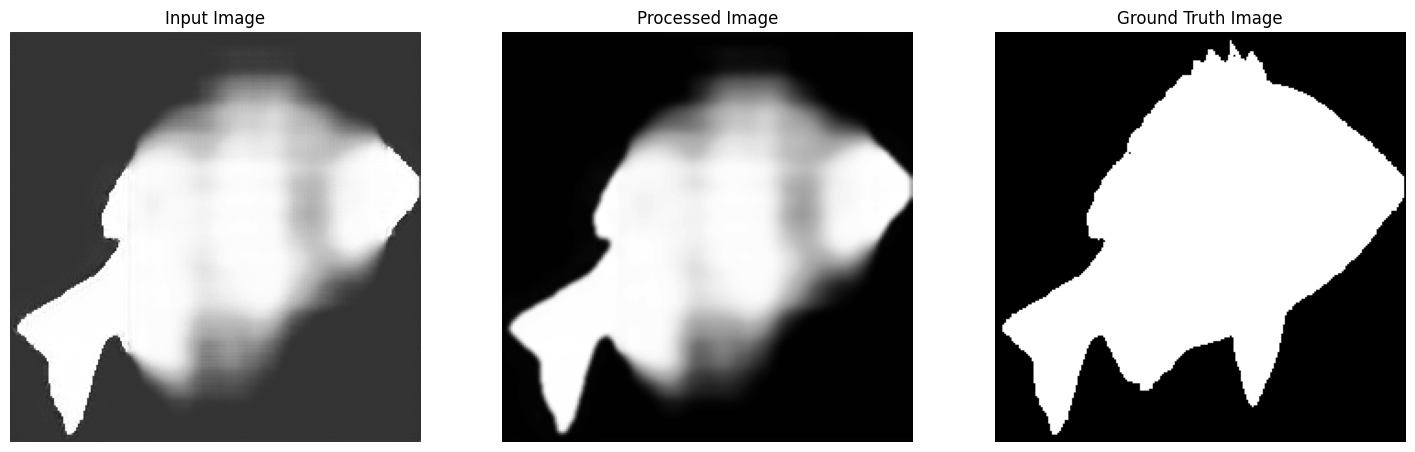

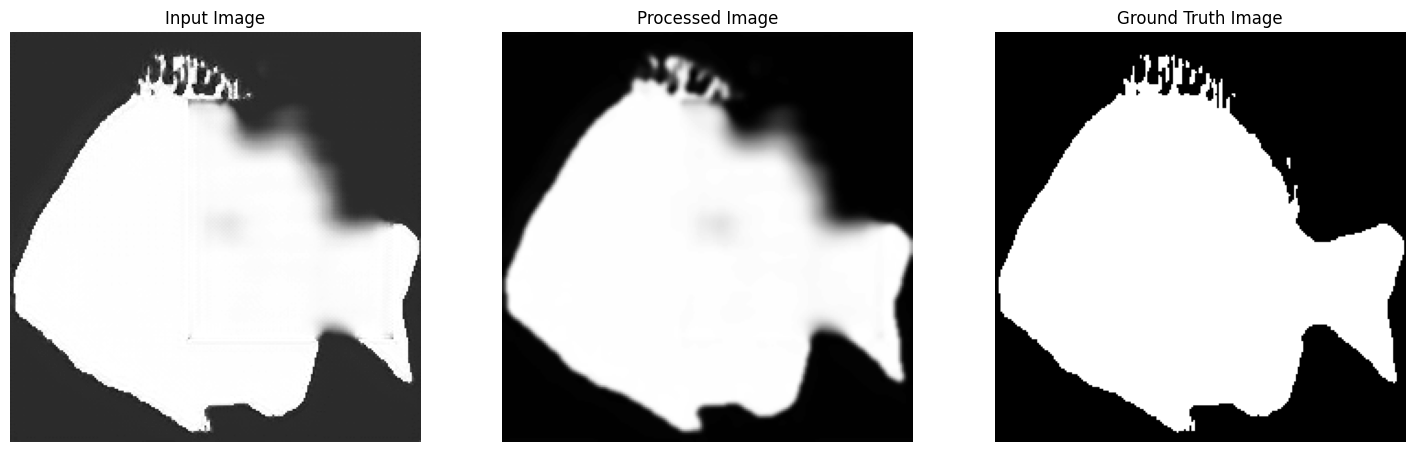

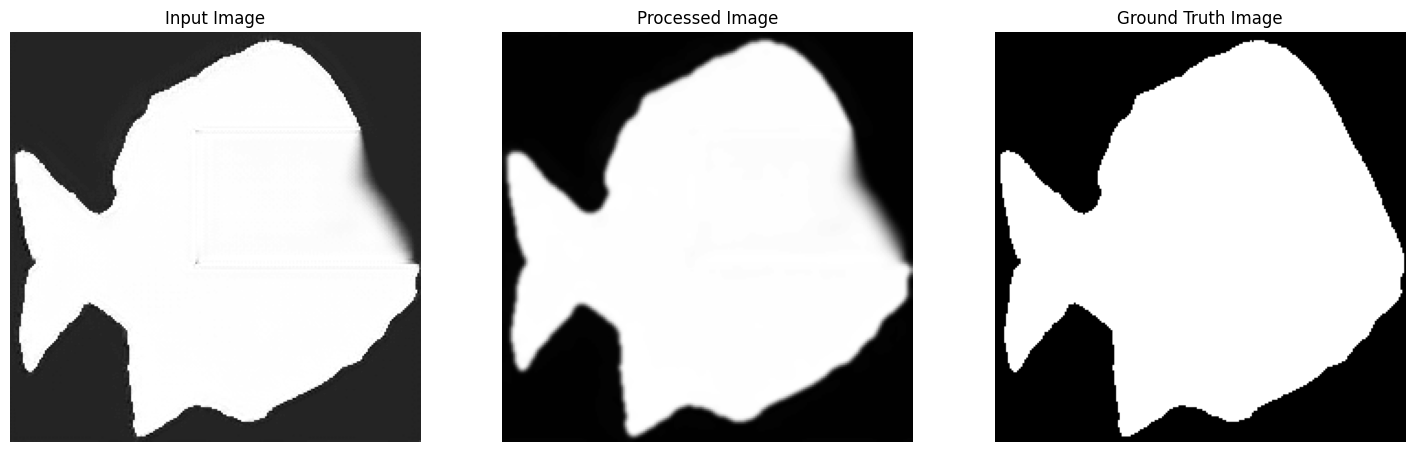

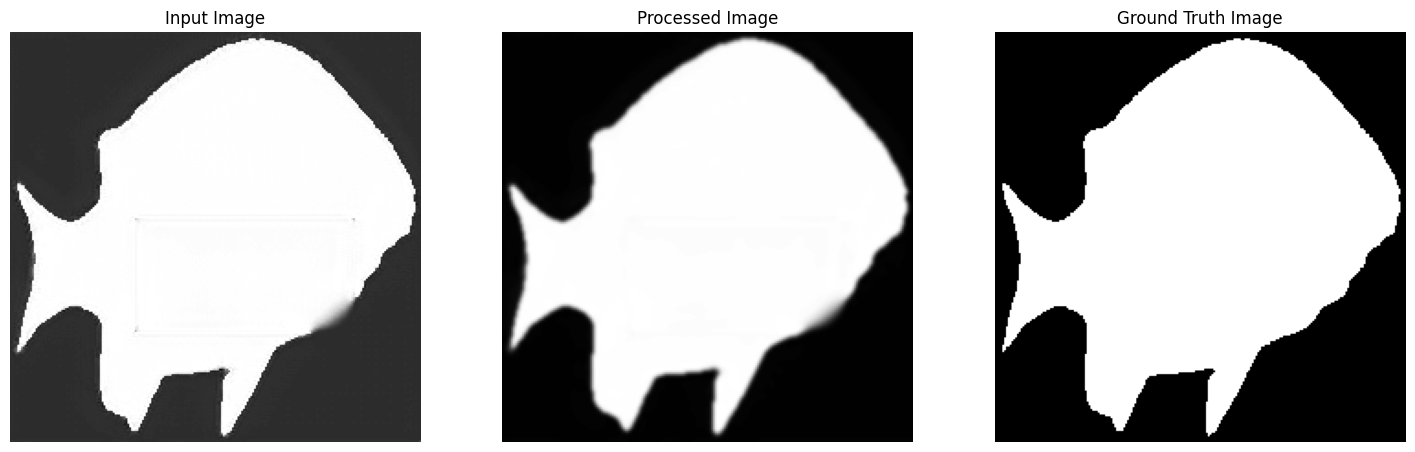

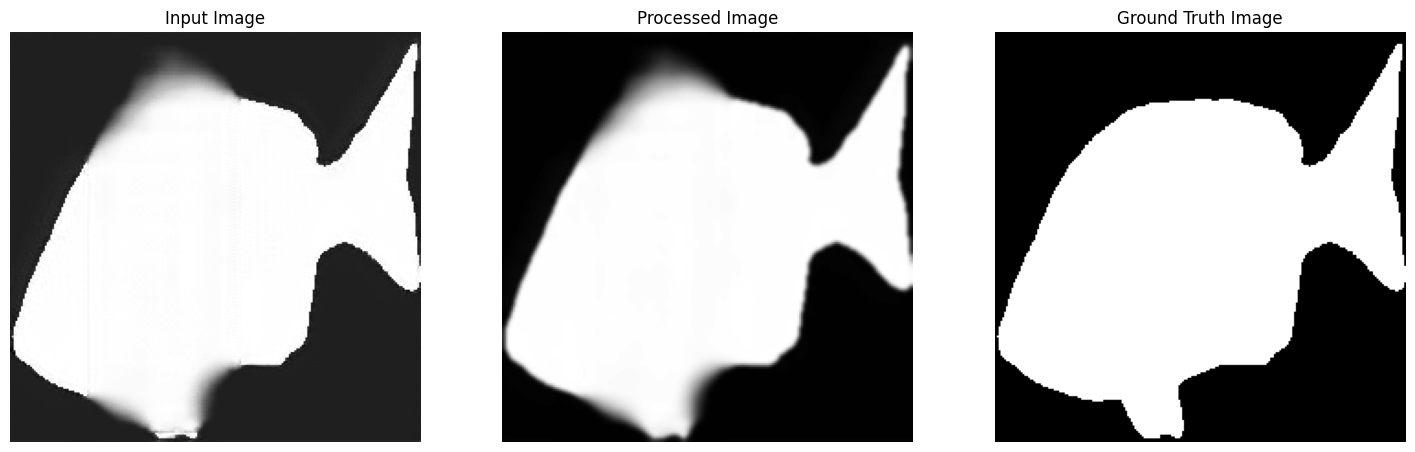

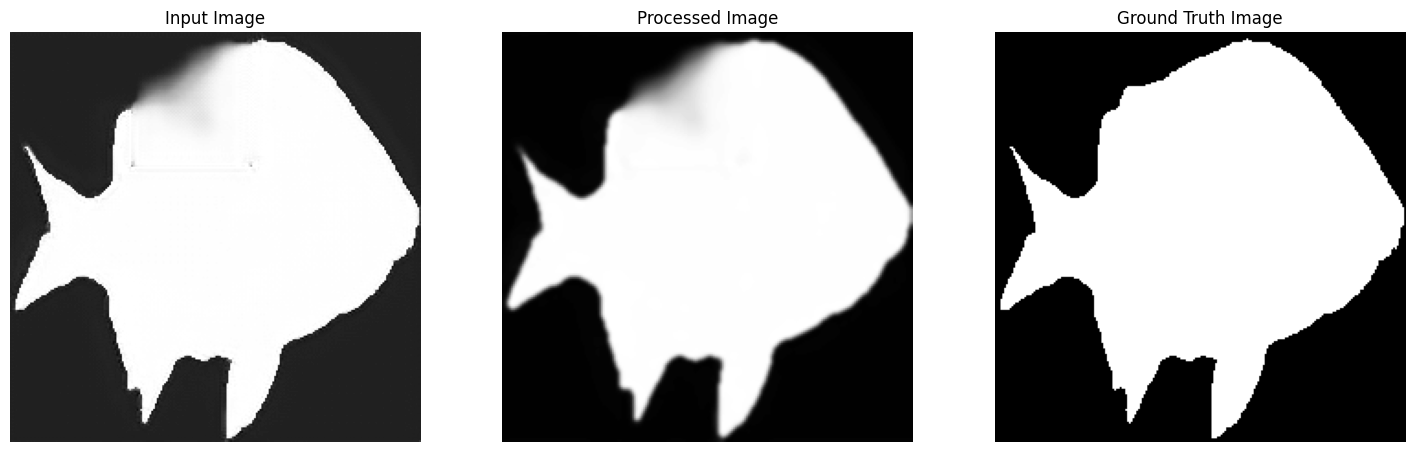

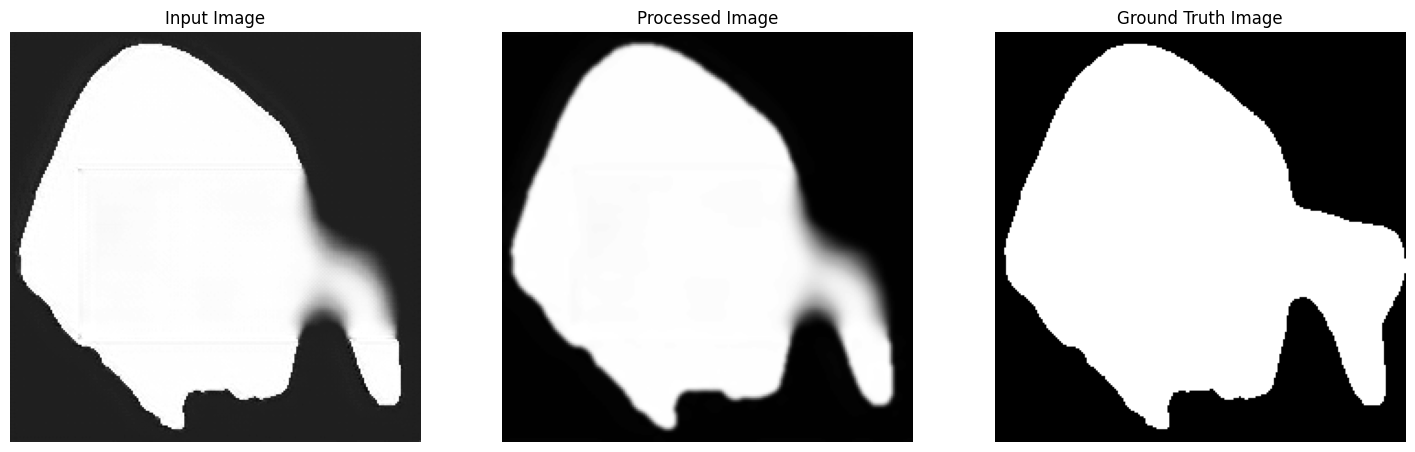

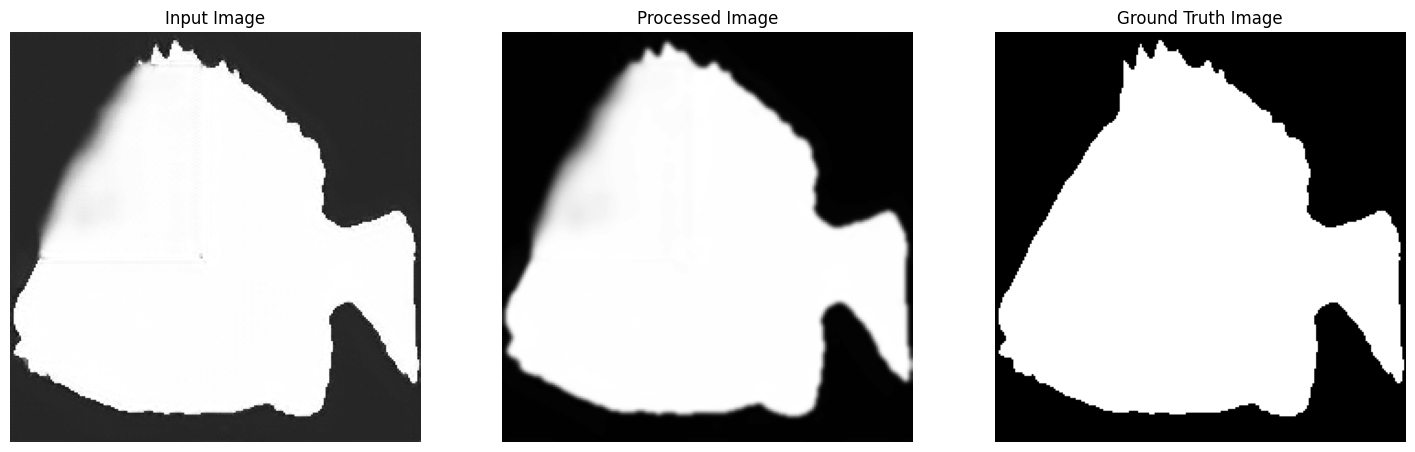

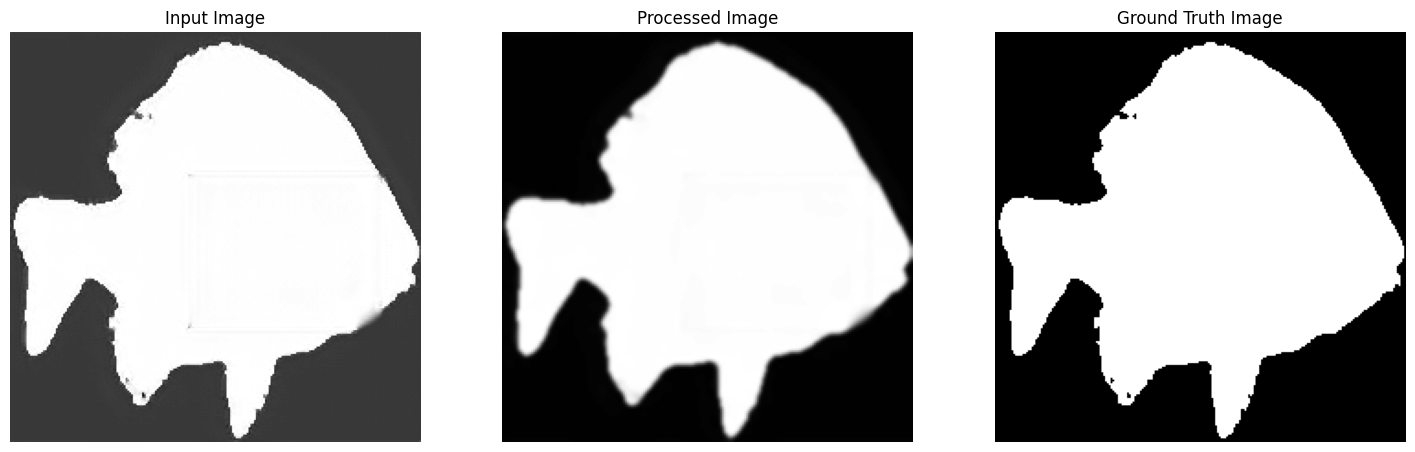

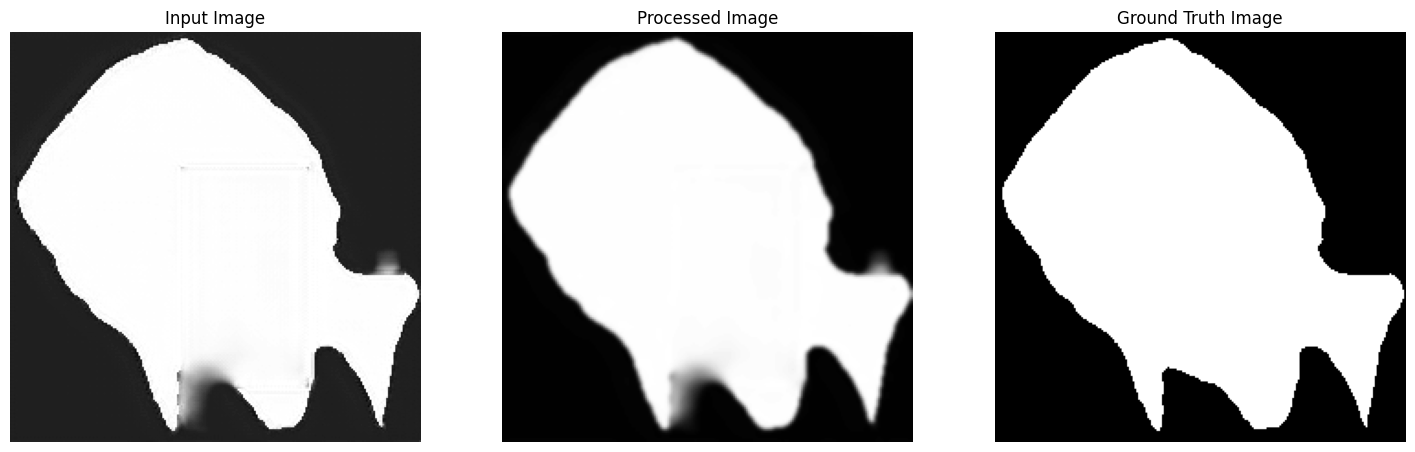

In [139]:
show_images('output' , 'output_post_processing', 'gt')

Try binary thresholding method

In [140]:
def binary_thresholding(image, threshold=0.5):

    # Apply thresholding: values above threshold set to 1, below set to 0
    image_bi = np.where(image > threshold, 1.0, 0.0)
    return image_bi

def post_processing_binary(input_folder, output_folder, threshold=0.5):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.webp')):
            continue

        # Load input image
        input_path = os.path.join(input_folder, filename)
        input_img = np.array(Image.open(input_path).convert("L"), dtype=np.float32) / 255.0

        # Apply binary thresholding
        processed_img = binary_thresholding(input_img, threshold)

        # Denormalize and save the processed image
        output_path = os.path.join(output_folder, filename)
        Image.fromarray((processed_img * 255).astype(np.uint8)).save(output_path)
        print(f"Saved processed image: {output_path}")


post_processing_binary('output' , 'output_binary')

Saved processed image: output_binary/fish_bp_2020-12-21-12-30_00-33-43_123_000041.png
Saved processed image: output_binary/fish_bp_2020-12-21-12-30_00-33-43_001_000047.png
Saved processed image: output_binary/fish_bp_2020-12-21-12-30_00-33-43_032_000068.png
Saved processed image: output_binary/fish_bp_2020-12-21-12-30_00-33-43_014_000052.png
Saved processed image: output_binary/swim_bp_2020-12-17-10-35_01-15-00_078_000010.png
Saved processed image: output_binary/fish_bp_2020-12-21-12-30_00-33-43_294_000035.png
Saved processed image: output_binary/swim_bp_2020-12-17-10-35_01-15-00_097_000000.png
Saved processed image: output_binary/fish_bp_2020-12-21-12-30_00-33-43_119_000040.png
Saved processed image: output_binary/fish_bp_2020-12-21-12-30_00-33-43_186_000059.png
Saved processed image: output_binary/fish_bp_2020-12-21-12-30_00-33-43_148_000049.png


In [141]:
# evaluation - run on your output image and gt image
evaluate_difference('output_binary', 'gt')

Average Mean Squared Error for test set: 0.1372


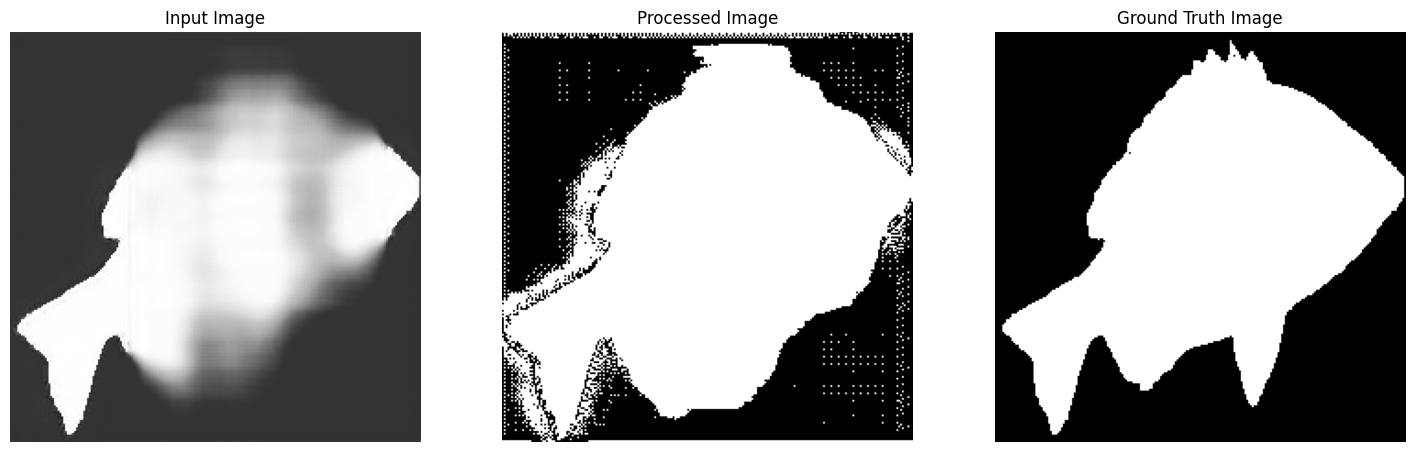

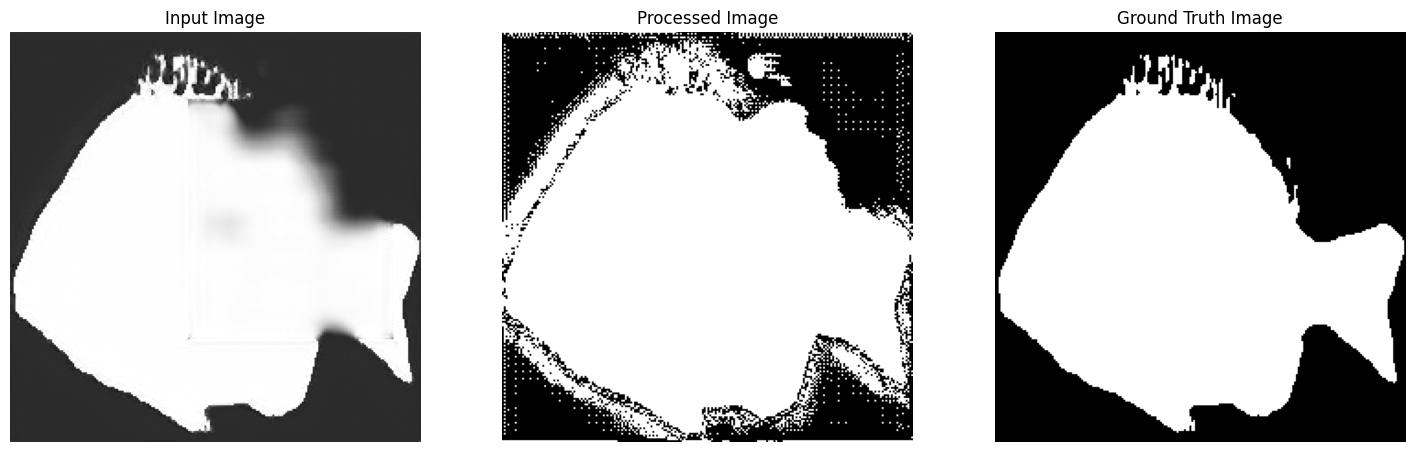

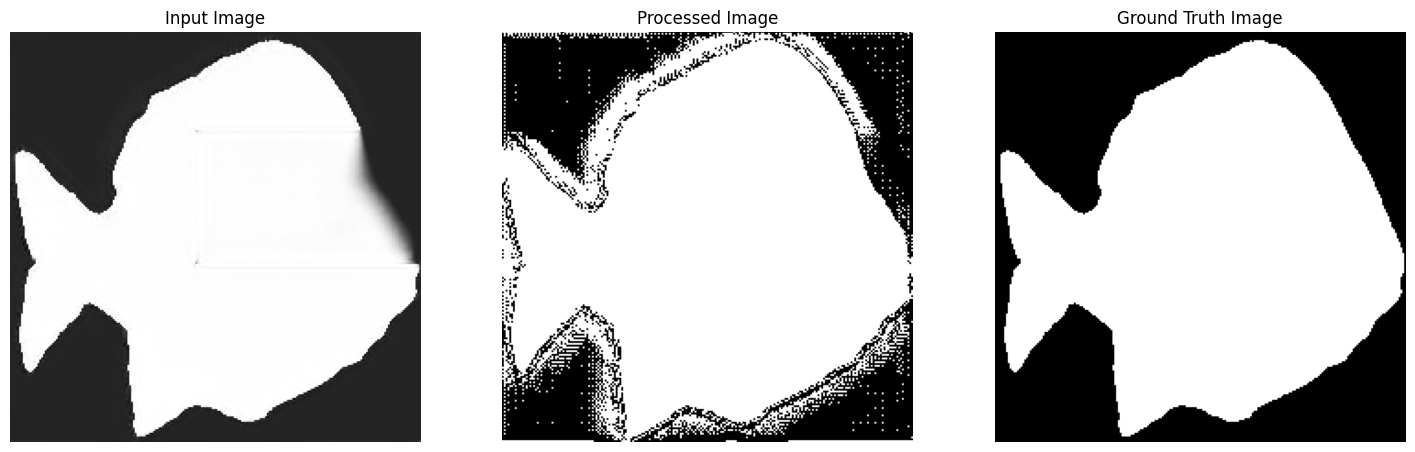

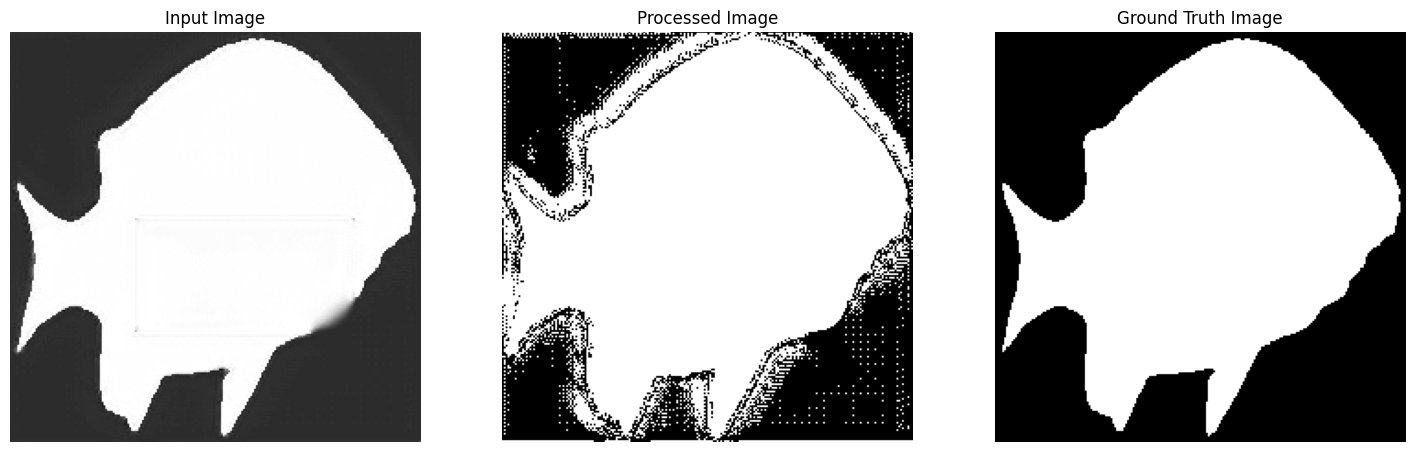

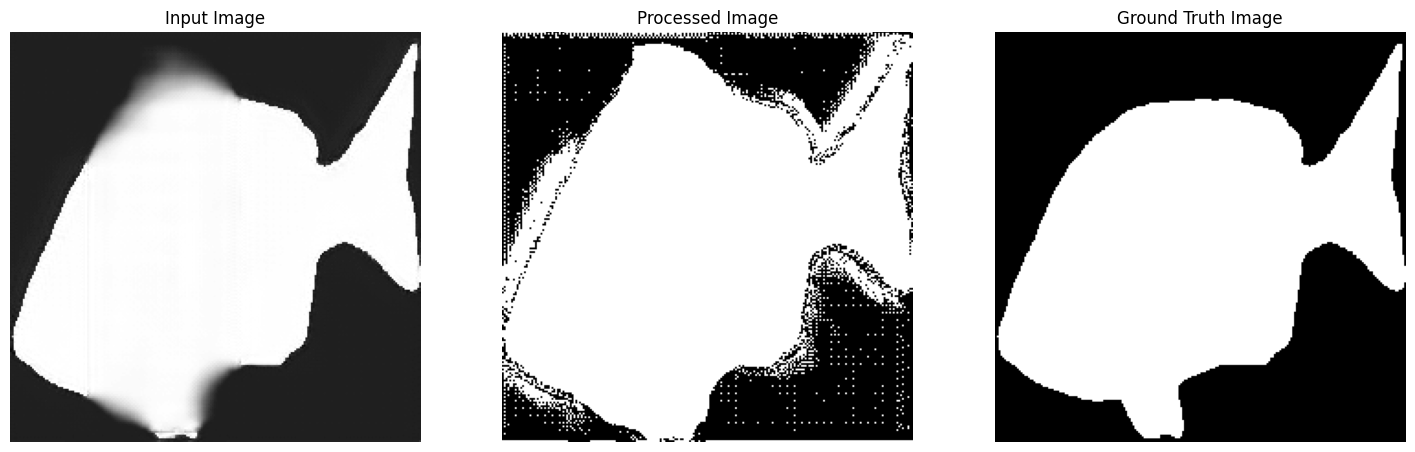

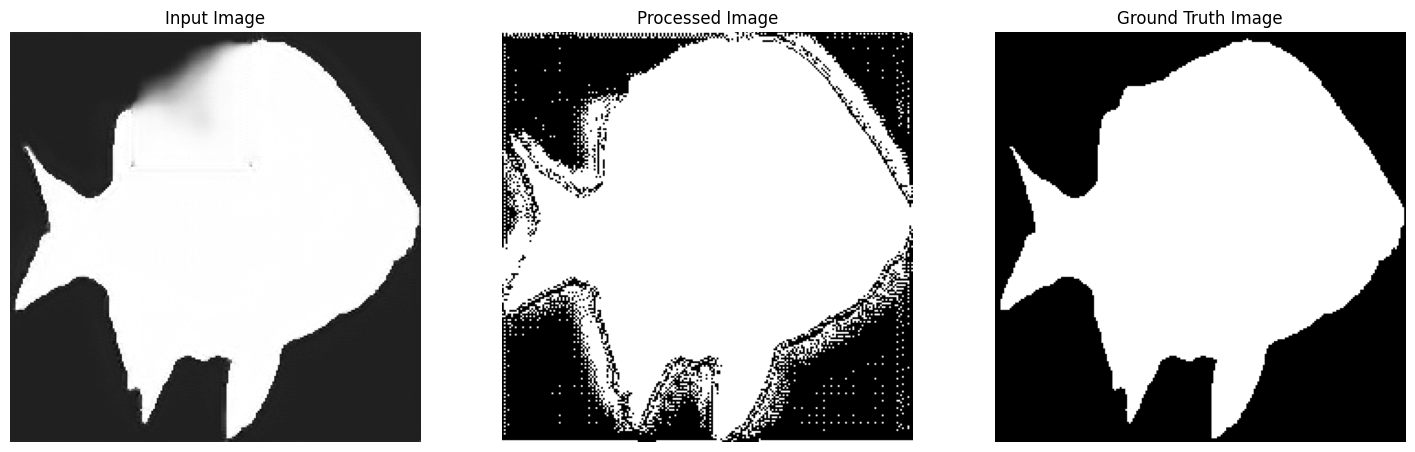

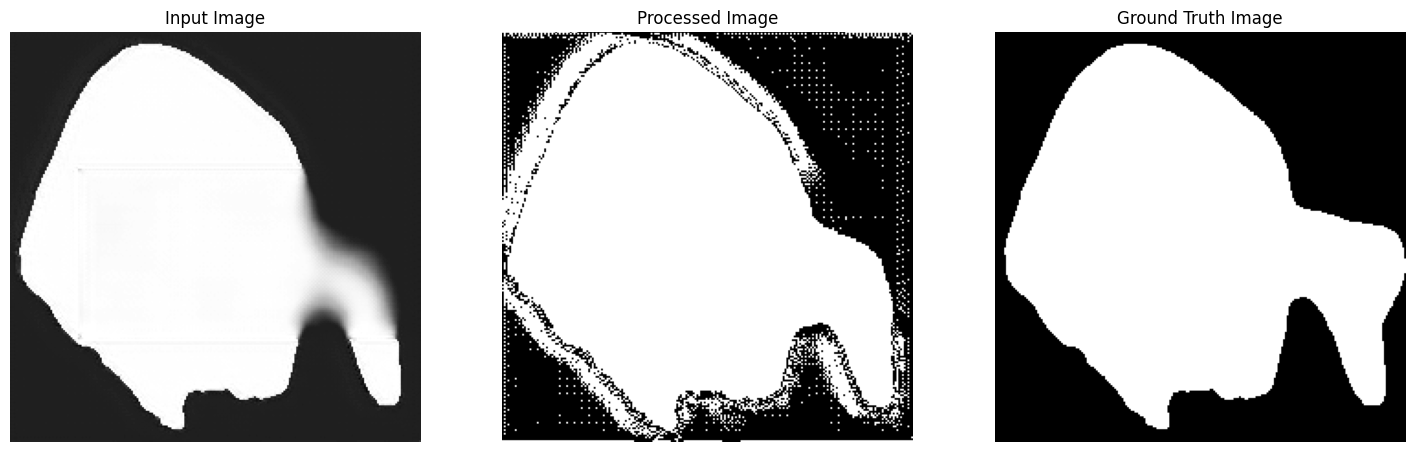

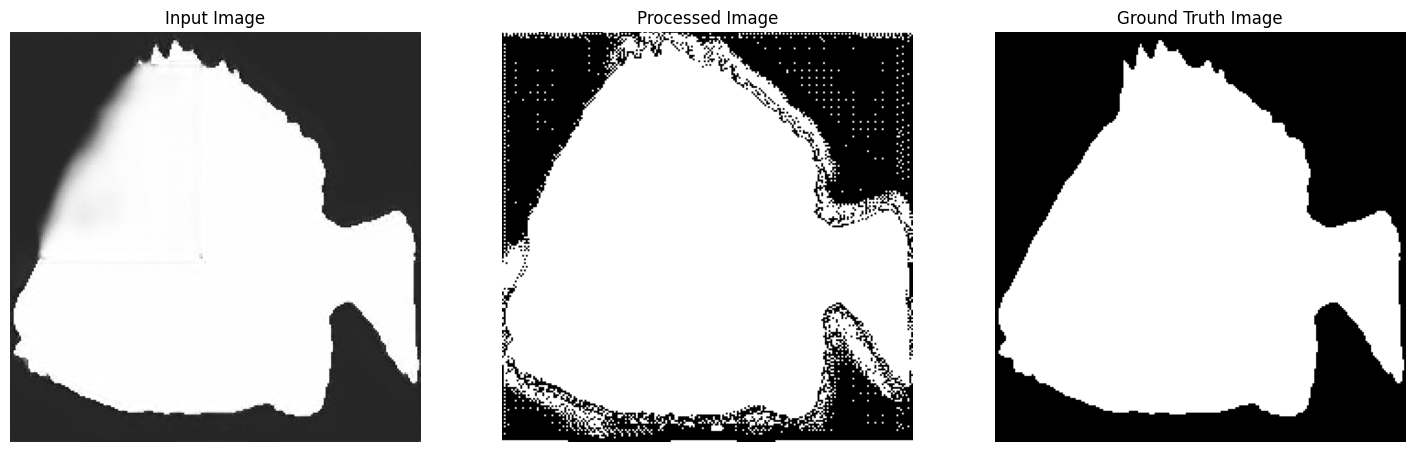

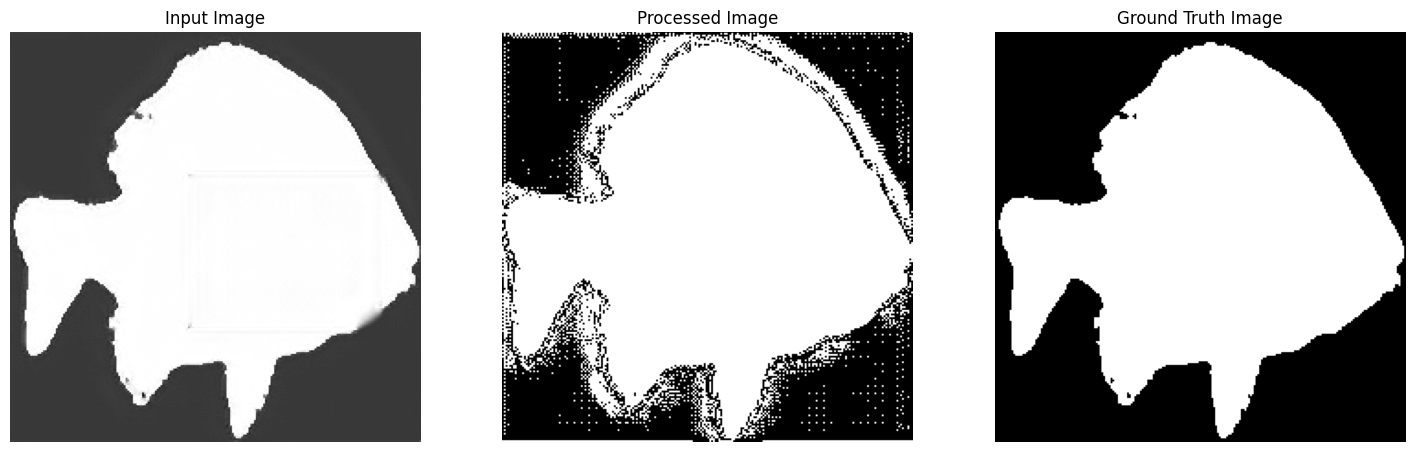

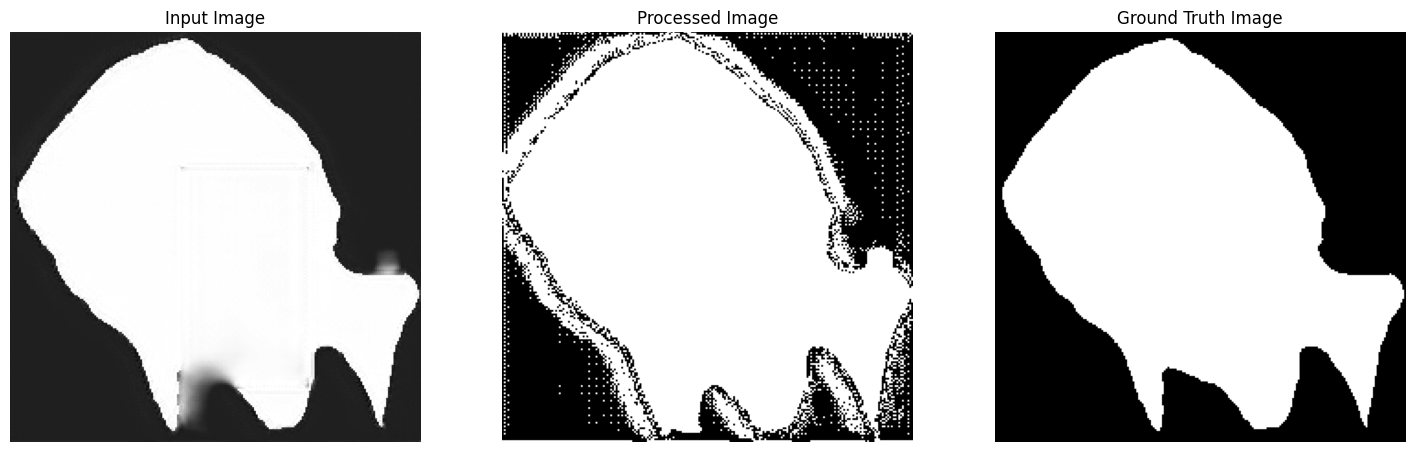

In [142]:
show_images('output' , 'output_binary', 'gt')